In [12]:
%pip install transformers
%pip install datasets
%pip install accelerate
%pip install transformers[sentencepiece]
%pip install torch
%pip install scikit-learn
%pip install evaluate
%pip install nltk
%pip install pandas
%pip install sklearn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
   

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [14]:
# Load the dataset
df = pd.read_csv('labelled_dataset.csv')

# Shuffle and split the dataset
# train: 70%, val: 20%, test: 10%
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42, shuffle=True)

# Convert the labels to integers
train_df['vulnerable'] = train_df['vulnerable'].astype(int)
val_df['vulnerable'] = val_df['vulnerable'].astype(int)
test_df['vulnerable'] = test_df['vulnerable'].astype(int)

In [15]:
def simple_tokenizer(text):
    return text.split()

# Criar um vocabulário (vamos usar os 5000 tokens mais frequentes como exemplo)
all_tokens = []
for snippet in df['file_content_in_il']:
    all_tokens.extend(simple_tokenizer(snippet))

# Contar a frequência dos tokens e manter os 5000 tokens mais comuns
counter = Counter(all_tokens)
vocab = {word: idx+1 for idx, (word, _) in enumerate(counter.most_common(5000))}  # idx+1 para não usar 0 (geralmente reservado para padding)

# Função para converter snippets em IDs de tokens
def encode_snippet(snippet, vocab, max_len=100):
    tokens = simple_tokenizer(snippet)
    token_ids = [vocab.get(token, 0) for token in tokens]  # Substitui palavras desconhecidas por 0 (padding)
    return token_ids[:max_len] + [0] * (max_len - len(token_ids))  # Pad ou truncar

# 4. Preparar os encodings para os datasets
train_encodings = [encode_snippet(snippet, vocab) for snippet in train_df['file_content_in_il']]
val_encodings = [encode_snippet(snippet, vocab) for snippet in val_df['file_content_in_il']]
test_encodings = [encode_snippet(snippet, vocab) for snippet in test_df['file_content_in_il']]


In [16]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {'input_ids': encodings}
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], dtype=torch.long) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask=None):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        final_output = lstm_out[:, -1, :]  # Pegamos o último estado oculto
        out = self.fc(final_output)
        return self.sigmoid(out).squeeze(1)

In [18]:
def evaluate_model(model, data_loader, device, validation=False):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    true_positives = 0
    false_positives = 0
    criterion = torch.nn.BCELoss()

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            # Cálculo de Precision
            true_positives += ((predictions == 1) & (labels == 1)).sum().item()
            false_positives += ((predictions == 1) & (labels == 0)).sum().item()
            true_negatives = ((predictions == 0) & (labels == 0)).sum().item()
            false_negatives = ((predictions == 0) & (labels == 1)).sum().item()

    accuracy = correct / total
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    if validation:
        return total_loss / len(data_loader), accuracy, precision


    # Gerar a matriz de confusão
    conf_matrix = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy())

    # Exibir a matriz de confusão
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Não Vulnerável", "Vulnerável"])
    disp.plot(cmap="Blues")
    
    print(f'Test Accuracy: {accuracy:.5f}')
    print(f'Test Precision: {precision:.5f}')
    print(f'Test Recall: {recall:.5f}')
    print(f'Test F1: {f1:.5f}')
    return accuracy, precision, recall, f1

In [19]:
def train_model(model, train_loader, val_loader, epochs, lr, device):
    criterion = nn.BCELoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    #optimizer = optim.RMSprop(model.parameters(), lr=lr, gamma=0.9)
    optimizer = optim.Adadelta(model.parameters(), lr=lr, rho=0.9)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss, val_acc, val_prec = evaluate_model(model, val_loader, device, validation=True)
        print(f'Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f} - Val Acc: {val_acc:.4f}')


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hiperparâmetros
vocab_size = len(vocab) + 1  # Tamanho do vocabulário (lembrando de adicionar 1 para o índice 0)
embedding_dim = 128
hidden_dim = 128
num_layers = 12
output_dim = 1
dropout = 0.5
lr = 0.00001
epochs = 400

Epoch 1/400 - Loss: 0.6882 - Val Acc: 0.6213
Epoch 2/400 - Loss: 0.6885 - Val Acc: 0.6213
Epoch 3/400 - Loss: 0.6883 - Val Acc: 0.6213
Epoch 4/400 - Loss: 0.6884 - Val Acc: 0.6213
Epoch 5/400 - Loss: 0.6883 - Val Acc: 0.6213
Epoch 6/400 - Loss: 0.6884 - Val Acc: 0.6213
Epoch 7/400 - Loss: 0.6883 - Val Acc: 0.6213
Epoch 8/400 - Loss: 0.6882 - Val Acc: 0.6213
Epoch 9/400 - Loss: 0.6884 - Val Acc: 0.6213
Epoch 10/400 - Loss: 0.6884 - Val Acc: 0.6213
Epoch 11/400 - Loss: 0.6882 - Val Acc: 0.6213
Epoch 12/400 - Loss: 0.6883 - Val Acc: 0.6213
Epoch 13/400 - Loss: 0.6884 - Val Acc: 0.6213
Epoch 14/400 - Loss: 0.6883 - Val Acc: 0.6213
Epoch 15/400 - Loss: 0.6883 - Val Acc: 0.6213
Epoch 16/400 - Loss: 0.6885 - Val Acc: 0.6213
Epoch 17/400 - Loss: 0.6884 - Val Acc: 0.6213
Epoch 18/400 - Loss: 0.6883 - Val Acc: 0.6213
Epoch 19/400 - Loss: 0.6883 - Val Acc: 0.6213
Epoch 20/400 - Loss: 0.6884 - Val Acc: 0.6213
Epoch 21/400 - Loss: 0.6884 - Val Acc: 0.6213
Epoch 22/400 - Loss: 0.6884 - Val Acc: 0.62

(0.635036496350365, 0.635036496350365, 1.0, 0.7767857142857143)

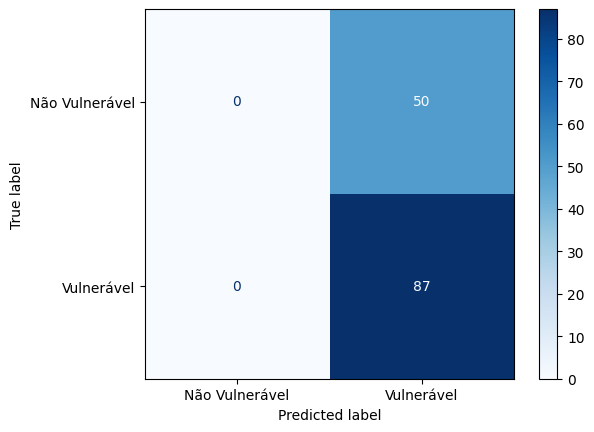

In [21]:
# Criar os Datasets
train_dataset = CustomDataset(train_encodings, train_df['vulnerable'].tolist())
val_dataset = CustomDataset(val_encodings, val_df['vulnerable'].tolist())
test_dataset = CustomDataset(test_encodings, test_df['vulnerable'].tolist())

# Criar os dataloaders
batch_size = 30
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

# Criar o modelo LSTM
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout)

# Treinar o modelo
train_model(model, train_loader, val_loader, epochs, lr, device)

# Avaliar o modelo
evaluate_model(model, test_loader, device)

Test Accuracy: 0.63504
Test Precision: 0.63504
Test Recall: 1.00000
Test F1: 0.77679


(0.635036496350365, 0.635036496350365, 1.0, 0.7767857142857143)

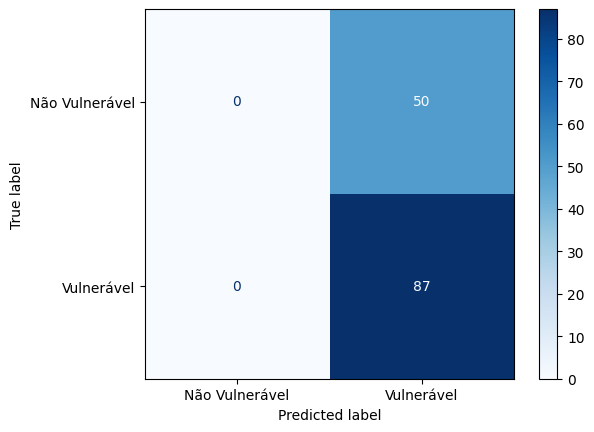

In [22]:
# Testar o modelo com o test_df
test_encodings = [encode_snippet(snippet, vocab) for snippet in test_df['file_content_in_il']]
test_dataset = CustomDataset(test_encodings, test_df['vulnerable'].tolist())
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
evaluate_model(model, test_loader, device)

